# Risk forecasting DNN model

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Dataset

In [172]:
# fetch closing values
sp500 = '^GSPC'
period='5y'
interval='1d'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=period, interval=interval)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# fetch VIX volatility data
vix = '^VIX'
vix_data = yf.Ticker(vix)
vix_history = vix_data.history(period=period, interval=interval)
vix_close = vix_history.Close.loc[vix_history.Close != 0][:-1]

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'close': close,
    'returns': (log_returns - log_returns.mean()) / log_returns.std(),
    'vix': (vix_close - vix_close.mean()) / vix_close.std(),
    'volatility': (volatility - volatility.mean()) / volatility.std()
})
X.dropna(inplace=True)
X

/Users/tom/opt/miniconda3/envs/ThesisEnv/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,close,returns,vix,volatility
Date,,,,
2017-06-12,2429.389893,-0.108055,-0.919188,-0.854626
2017-06-13,2440.350098,0.316881,-1.036551,-0.784186
2017-06-14,2437.919922,-0.109379,-1.011724,-0.773167
2017-06-15,2432.459961,-0.205970,-0.982383,-0.742372
2017-06-16,2433.149902,-0.010141,-1.041065,-0.745575
...,...,...,...,...
2022-05-25,3978.729980,0.697190,0.989077,0.177935
2022-05-26,4057.840088,1.494383,0.890899,0.275589
2022-05-27,4158.240234,1.862902,0.690029,0.382723


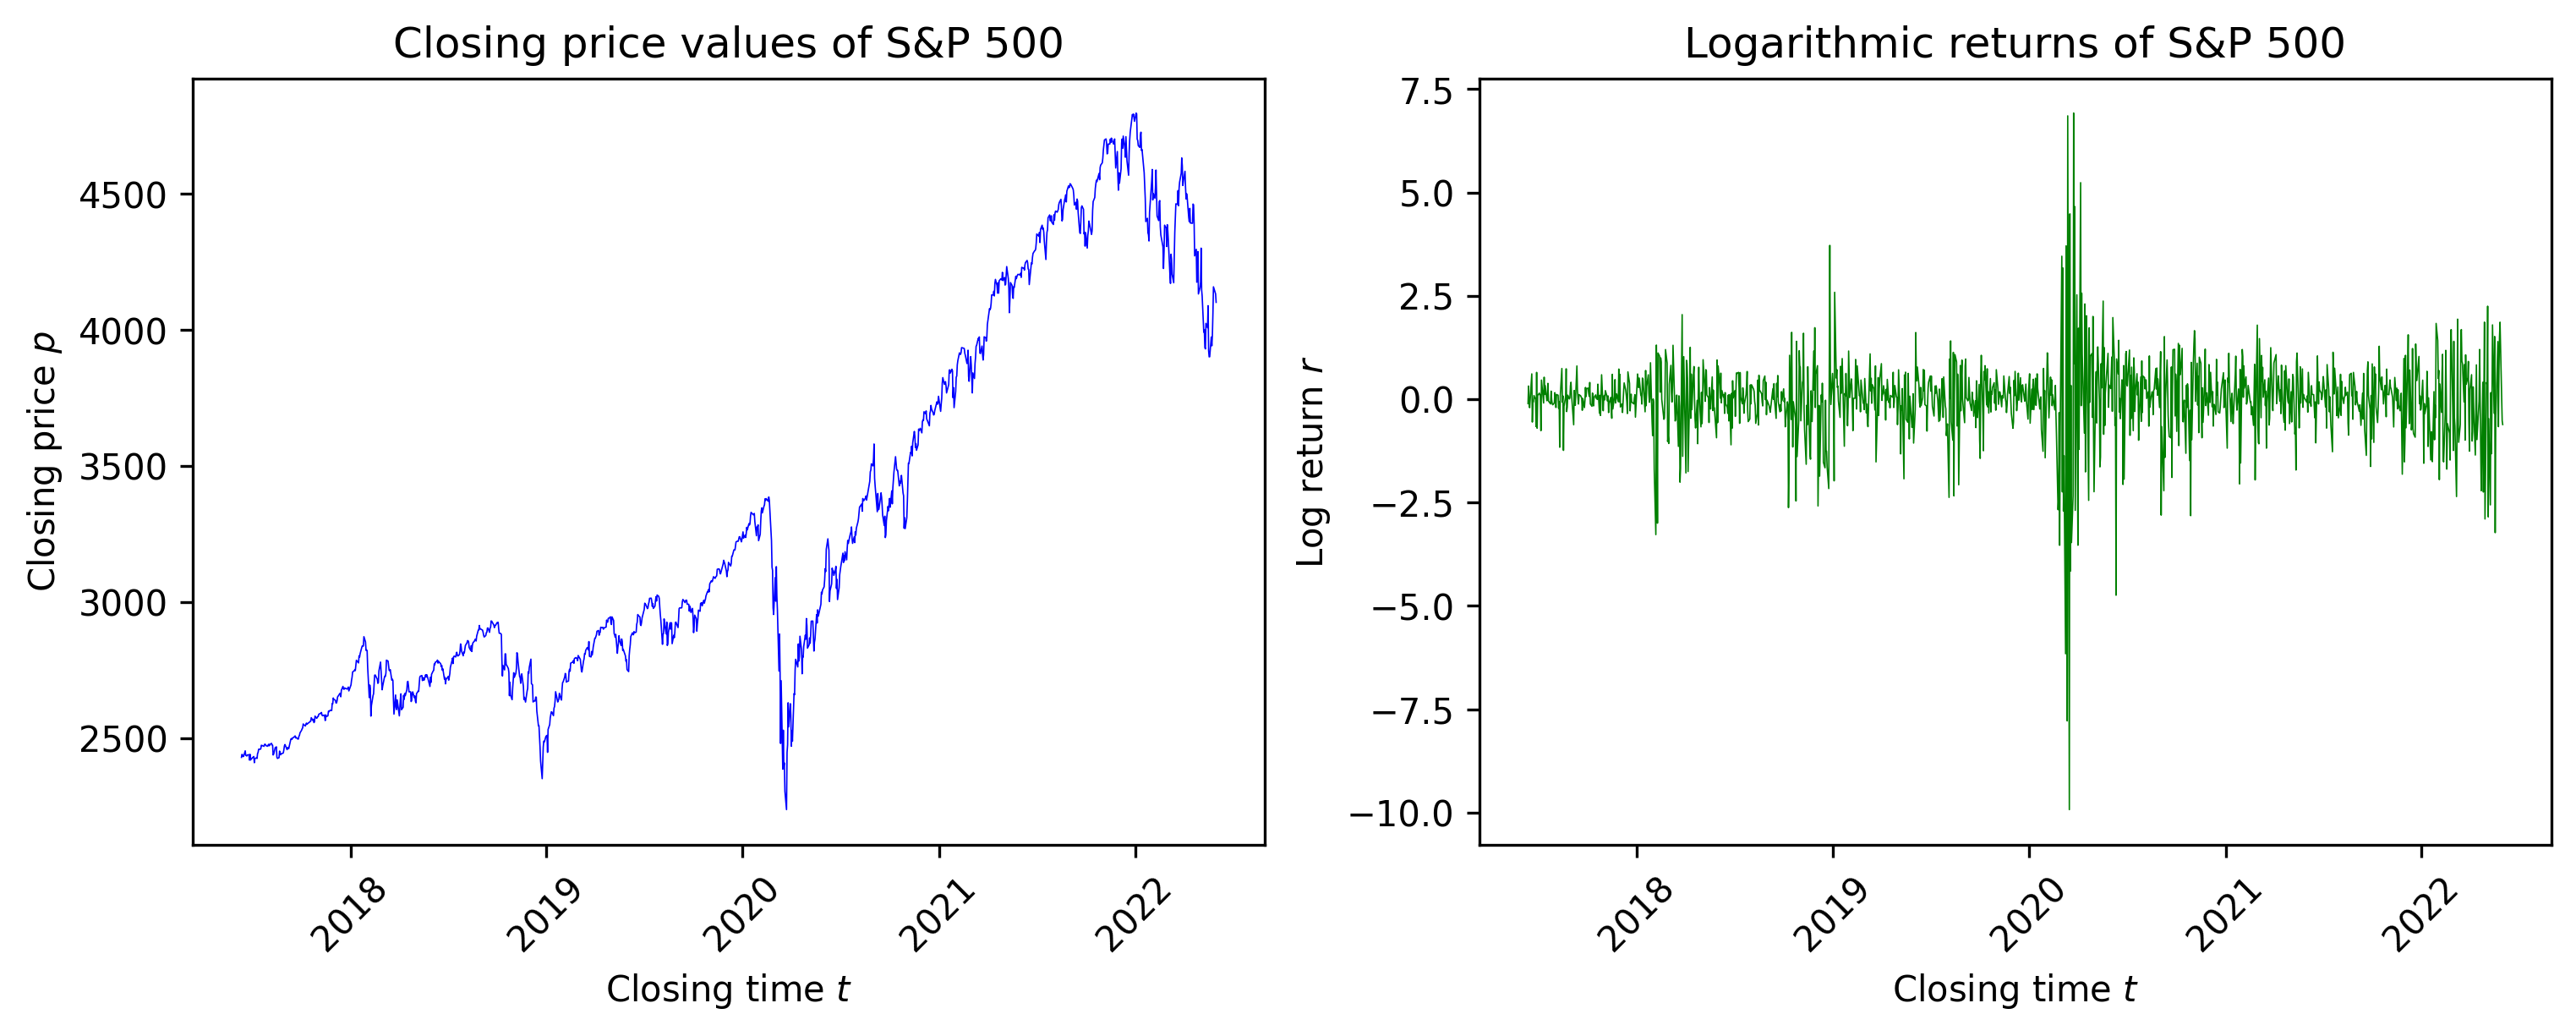

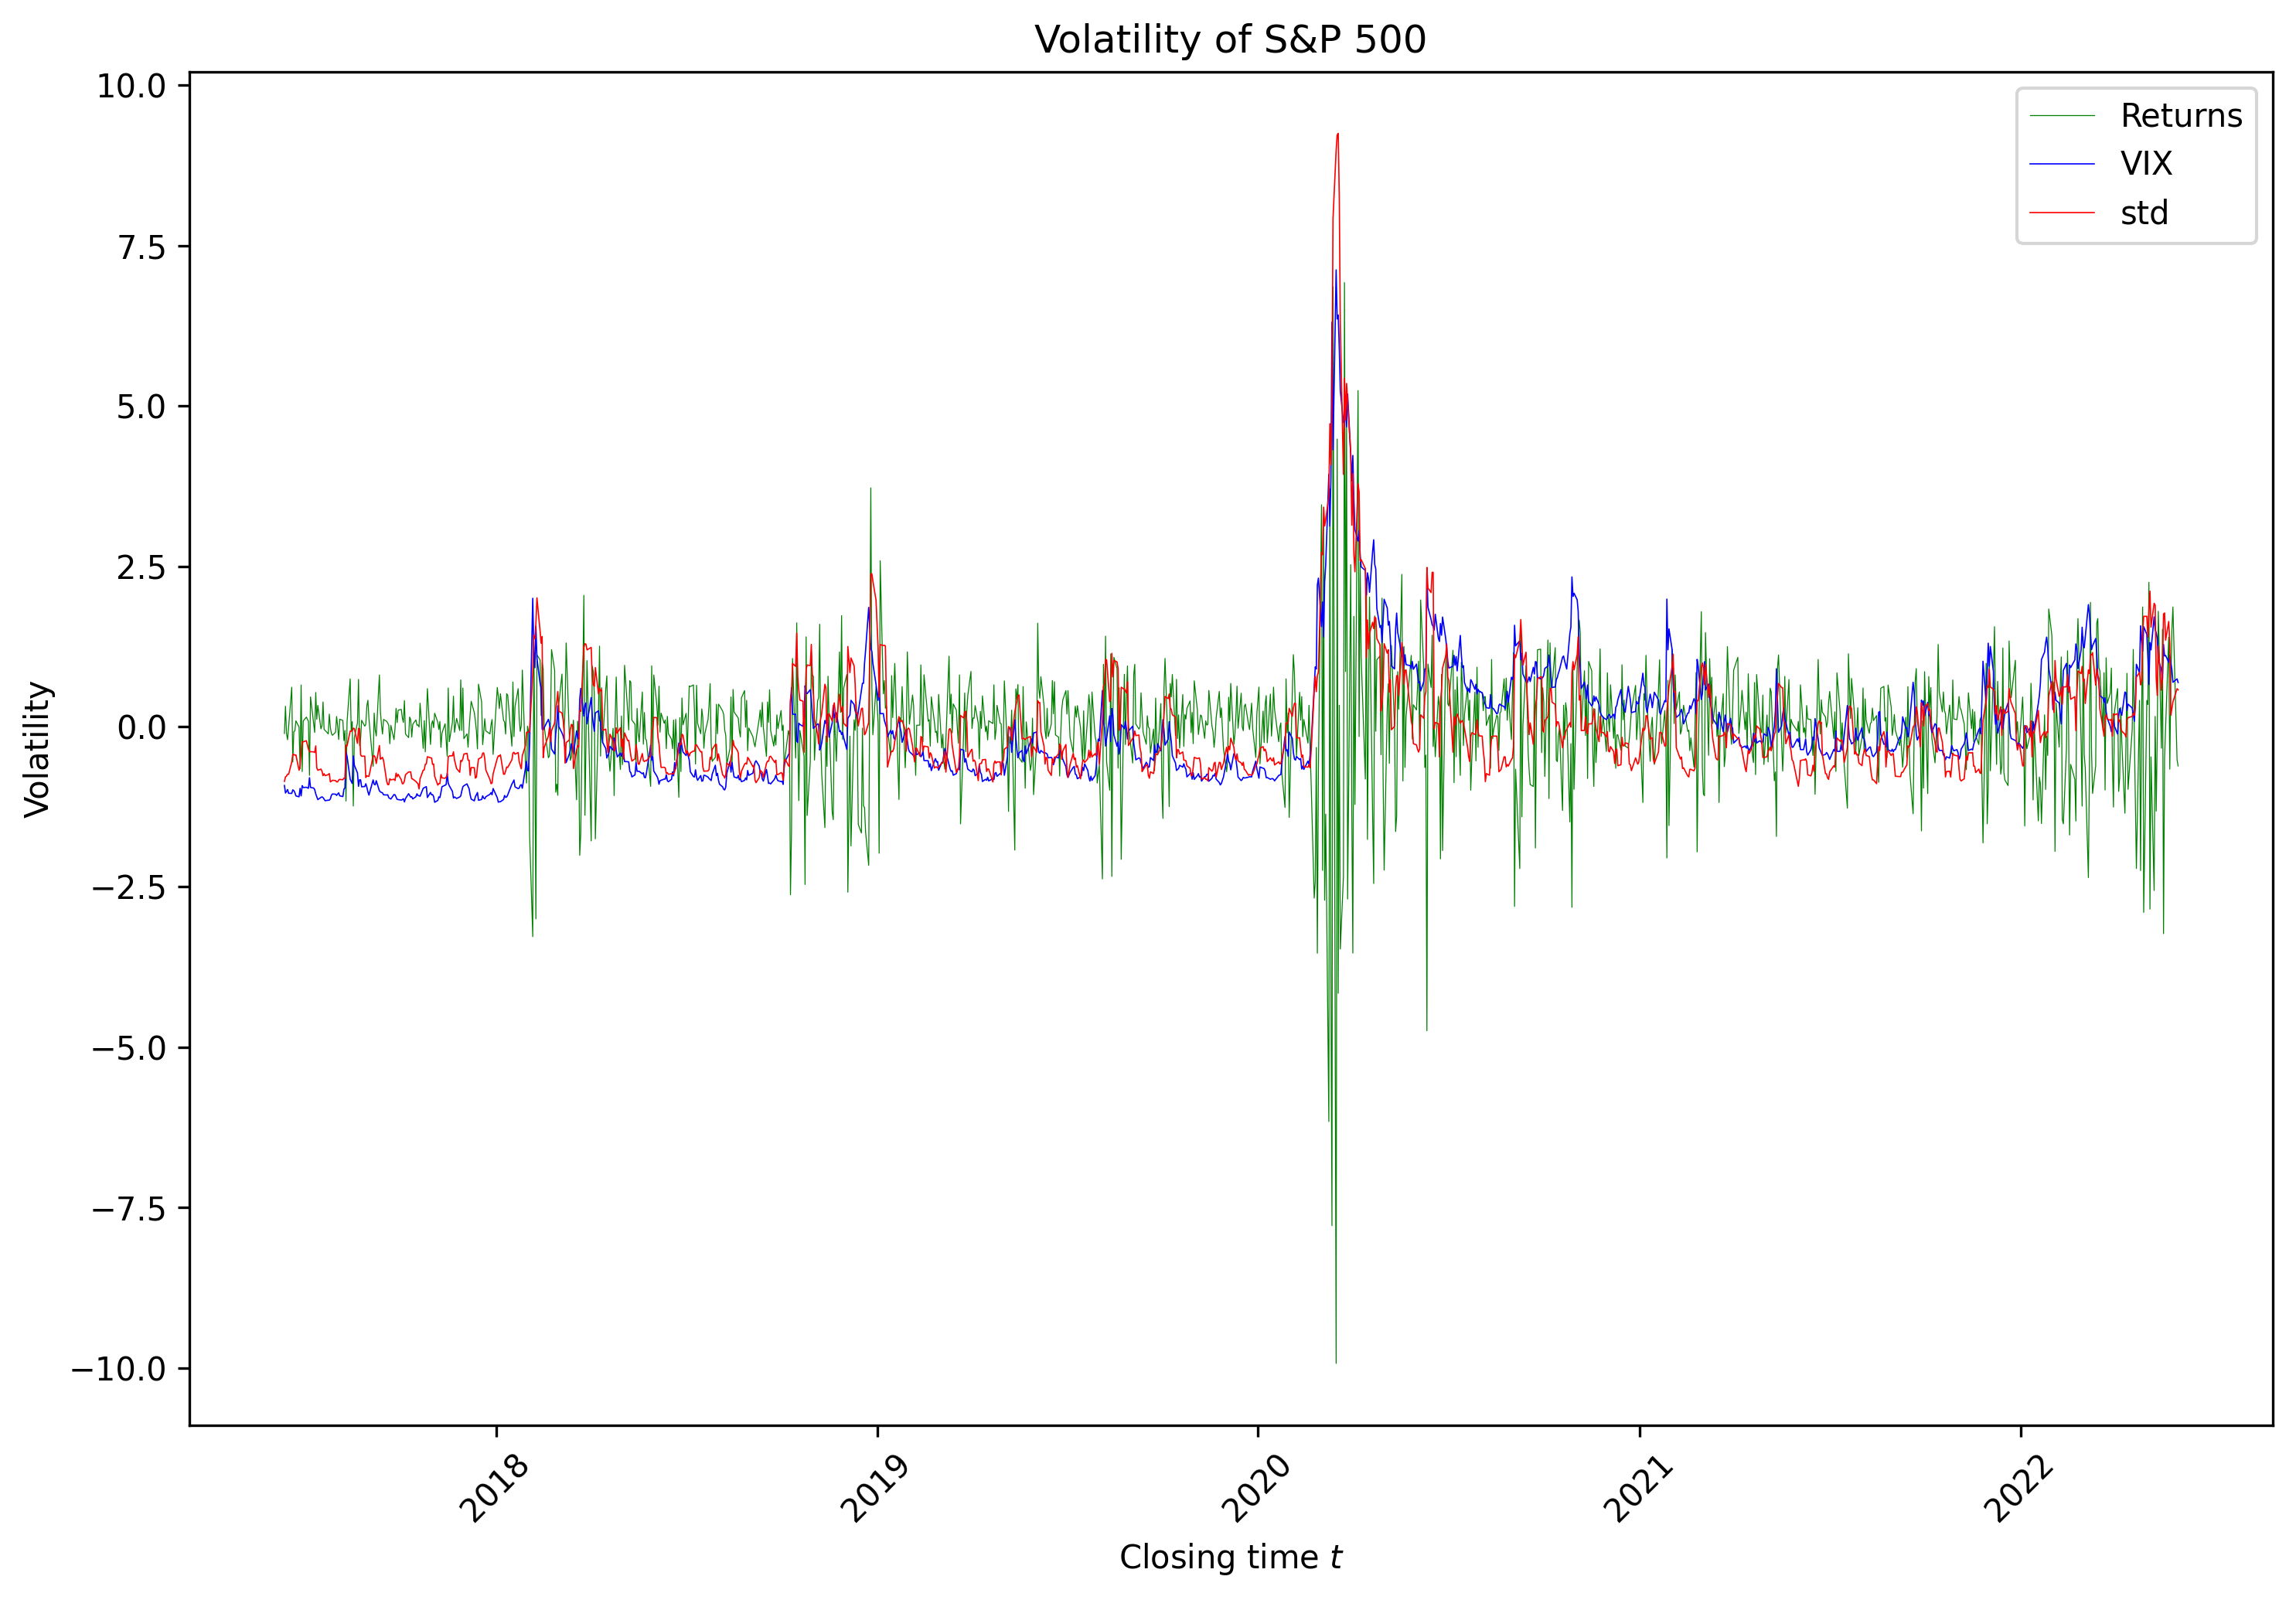

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

ax[0].plot(X.close, linewidth=0.4, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.4, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
ax.plot(X.returns, linewidth=0.3, color='g', label='Returns')
ax.plot(X.vix, linewidth=0.4, color='b', label='VIX')
ax.plot(X.volatility, linewidth=0.4, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [184]:
# build instances X as sequence of 20 vix values, and labels y as subsequent vix value
lookback = 10
X_data = []
y_data = []

for i in range(X.vix.shape[0] - lookback):
    X_data.append(X.vix[i: i + lookback])
    y_data.append(X.vix[i + lookback])

X_data = np.array(X_data)
y_data = np.array(y_data)

In [185]:
# split into training and testing data
train_test_split = math.floor(X_data.shape[0] * 0.9)

X_train = X_data[:train_test_split]
X_train = np.expand_dims(X_train, 2)
y_train = y_data[:train_test_split]

X_test = X_data[train_test_split:]
X_test = np.expand_dims(X_test, 2)
y_test = y_data[train_test_split:]

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((1118, 10, 1), (1118,)), ((125, 10, 1), (125,)))

In [186]:
# build RNN comprising of one LSTM layer and one FCN layer
model = Sequential([
    LSTM(10, input_shape=(X_train.shape[1:])),
    Dense(1)
])

model.compile(loss='mae', optimizer='adam')

In [187]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
35/35 [==============================] - 2s 6ms/step - loss: 0.5931
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 0.3946
Epoch 3/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3036
Epoch 4/10
35/35 [==============================] - 0s 4ms/step - loss: 0.2732
Epoch 5/10
35/35 [==============================] - 0s 4ms/step - loss: 0.2541
Epoch 6/10
35/35 [==============================] - 0s 4ms/step - loss: 0.2377
Epoch 7/10
35/35 [==============================] - 0s 4ms/step - loss: 0.2255
Epoch 8/10
35/35 [==============================] - 0s 4ms/step - loss: 0.2160
Epoch 9/10
35/35 [==============================] - 0s 3ms/step - loss: 0.2076
Epoch 10/10
35/35 [==============================] - 0s 3ms/step - loss: 0.2004


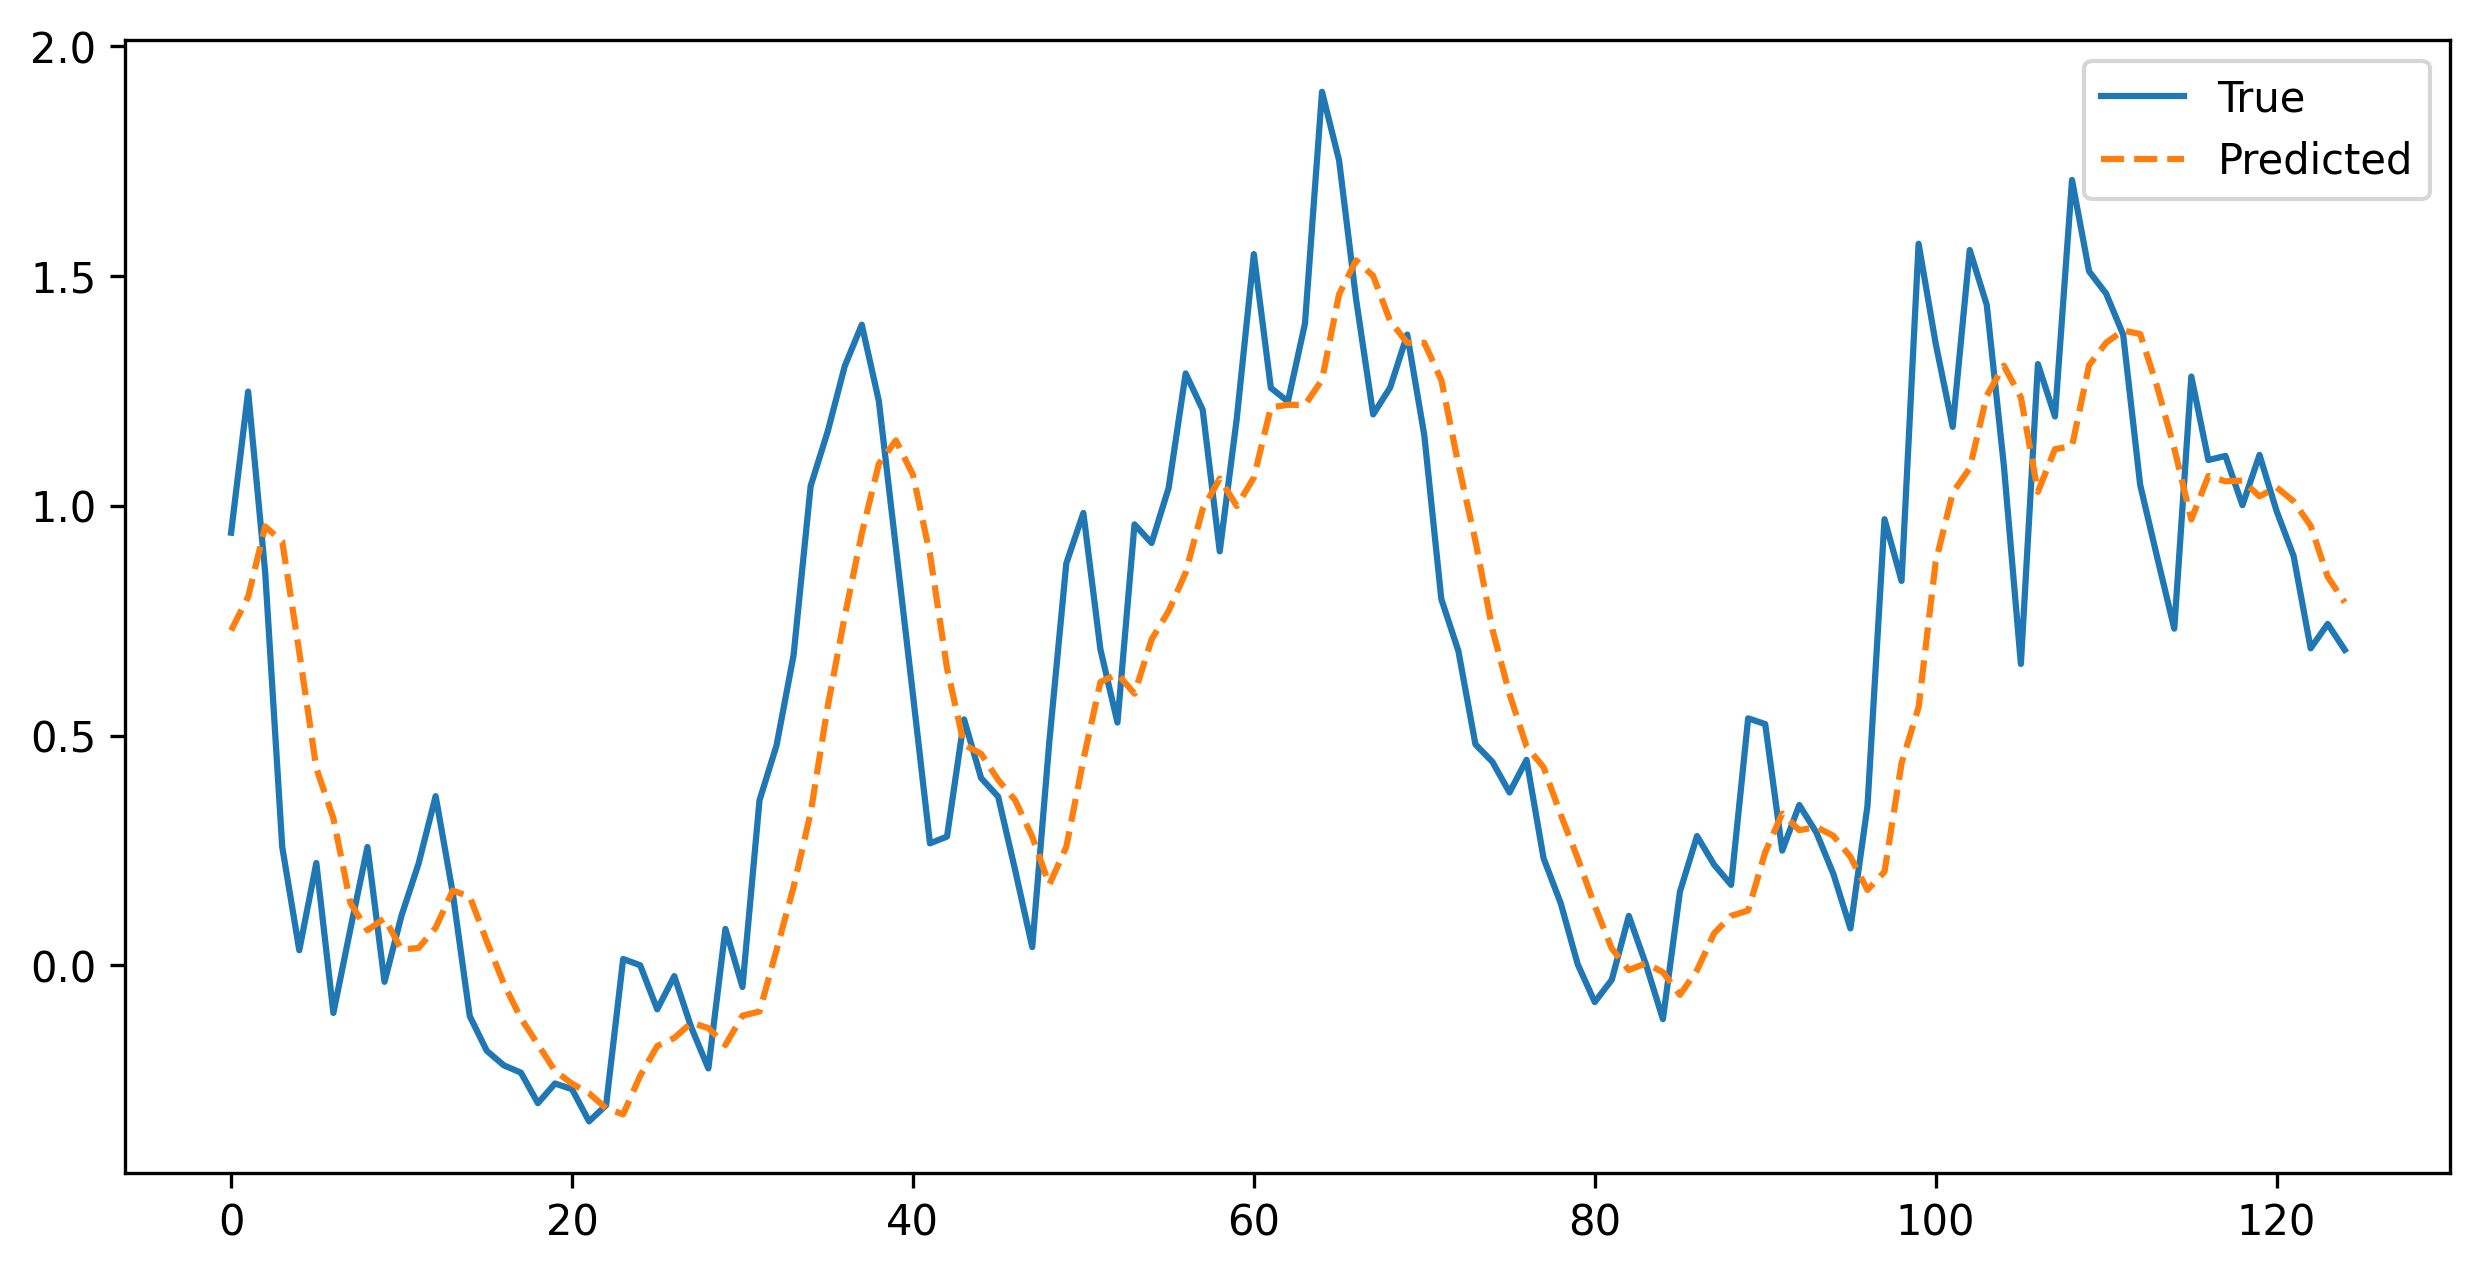

In [188]:
predictions = model.predict(X_test)

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(y_test,label='True')
plt.plot(predictions, linestyle='--', label='Predicted')
plt.legend()
plt.show()